In [1]:
# Ссылка на индекс https://finance.yahoo.com/quote/IMOEX.ME/history/

In [2]:
import requests
import apimoex
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import matplotlib.pyplot as plt
from pypfopt import plotting, EfficientFrontier
import plotly.graph_objs as go

In [3]:
#Beta calculation

def matrix_beta(df):
    # Extract the market index (last column)
    X = df.iloc[:, [-1]].values
    # Add an additional column for the intercept (initialise as 1's)
    X = np.concatenate([np.ones_like(X), X], axis=1)
    # Extract dependent variables (all but last column)
    Y = df.iloc[:, :-1].values
    # Apply matrix algebra for linear regression model
    beta = np.linalg.pinv(X.T @ X) @ X.T @ Y
    # Extract the asset names
    asset_names = df.columns[:-1]
    return pd.Series(beta[1], index=asset_names, name='Beta')

In [45]:
# Get close price data

# Trade mode
board = 'TQBR'

# Start and end date
start = "2022-06-01"
end = "2023-04-01"

end = datetime.strptime(end, "%Y-%m-%d")
end = end + timedelta(days=1)
end = end.strftime("%Y-%m-%d")

# Load tickers from file
with open("TICKERS.txt", "r") as TICKs:
    TICKs = [line.rstrip() for line in TICKs]

# Initialize an empty dataframe for the combined data
all_data = None

process = 0
with requests.Session() as session:
    for TICK in TICKs:
        process = process + 1
        print(round(process / len(TICKs) * 100, 2), "%")
        data = apimoex.get_board_history(session, TICK, board=board, start=start, end=end)
        
        if not data:
            continue
        
        df = pd.DataFrame(data)
        df = df[['TRADEDATE', 'CLOSE']]
        
        # Rename 'CLOSE' column to the ticker name
        df = df.rename(columns={'CLOSE': TICK})

        # If all_data is empty, assign df to it. Otherwise, merge on 'TRADEDATE'
        if all_data is None:
            all_data = df
        else:
            all_data = all_data.merge(df, on='TRADEDATE', how='outer')

all_data['TRADEDATE'] = pd.to_datetime(all_data['TRADEDATE'])

# Sort by TRADEDATE
all_data = all_data.sort_values(by='TRADEDATE', ascending=True)

# Set TRADEDATE as index column
all_data.set_index('TRADEDATE', inplace=True)

df = all_data
df

1.41 %
2.82 %
4.23 %
5.63 %
7.04 %
8.45 %
9.86 %
11.27 %
12.68 %
14.08 %
15.49 %
16.9 %
18.31 %
19.72 %
21.13 %
22.54 %
23.94 %
25.35 %
26.76 %
28.17 %
29.58 %
30.99 %
32.39 %
33.8 %
35.21 %
36.62 %
38.03 %
39.44 %
40.85 %
42.25 %
43.66 %
45.07 %
46.48 %
47.89 %
49.3 %
50.7 %
52.11 %
53.52 %
54.93 %
56.34 %
57.75 %
59.15 %
60.56 %
61.97 %
63.38 %
64.79 %
66.2 %
67.61 %
69.01 %
70.42 %
71.83 %
73.24 %
74.65 %
76.06 %
77.46 %
78.87 %
80.28 %
81.69 %
83.1 %
84.51 %
85.92 %
87.32 %
88.73 %
90.14 %
91.55 %
92.96 %
94.37 %
95.77 %
97.18 %
98.59 %
100.0 %


,CBOM,ALRS,VTBR,RUAL,ENPG,BSPB,AFKS,AFLT,BELU,GAZP,...,MRKU,MRKP,MRKC,SVAV,SNGS,SNGSP,TGKN,TRMK,VSMO,MGTSP
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2022-06-01,5.602,74.82,0.018495,57.990,613.0,64.50,13.190,27.94,2312,297.69,...,0.1878,0.2111,0.2850,177.5,22.200,35.590,0.00262,53.90,58680,684
2022-06-02,5.532,72.96,0.017935,60.500,609.5,64.78,12.826,26.98,2296,296.00,...,0.1890,0.2106,0.2838,175.0,22.000,36.050,0.00261,52.64,61000,682
2022-06-03,5.461,70.12,0.017550,60.800,594.5,65.22,12.843,26.74,2275,297.00,...,0.1890,0.2121,0.2828,173.5,21.605,35.915,0.00262,51.74,60600,660
2022-06-06,5.442,71.22,0.017415,60.405,576.0,66.80,12.540,25.92,2336,296.50,...,0.1914,0.2119,0.2810,175.0,21.475,36.020,0.00263,51.70,60820,654
2022-06-07,5.433,71.05,0.017210,60.295,572.0,66.22,12.470,27.20,2330,297.99,...,0.1910,0.2109,0.2804,174.5,21.735,35.830,0.00264,52.02,60660,680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,7.157,65.44,0.018340,41.395,415.5,154.00,14.508,32.92,4009,172.33,...,0.1950,0.2094,0.2874,240.5,23.760,31.695,0.00366,104.48,47040,1332
2023-03-28,7.408,64.87,0.018300,41.115,410.5,152.10,14.391,32.36,4038,171.07,...,0.1946,0.2089,0.2872,239.0,23.645,31.505,0.00380,103.00,46500,1324
2023-03-29,7.454,64.56,0.018340,41.030,420.0,150.09,14.634,32.27,4032,170.95,...,0.1950,0.2084,0.2876,238.0,23.775,31.460,0.00375,102.70,46580,1312


In [46]:
# Maximum Sharpe Ratio Portfolio

assets = df.iloc[:, :].columns

# Calculate all assets risk and returns

mu = expected_returns.mean_historical_return(df.iloc[:, :].ffill())
s = risk_models.CovarianceShrinkage(df.iloc[:, :].ffill()).ledoit_wolf()


# Use efficient frontier to determine weights

ef = EfficientFrontier(mu, s)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()

print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('CBOM', 0.0), ('ALRS', 0.0), ('VTBR', 0.0), ('RUAL', 0.0), ('ENPG', 0.0), ('BSPB', 0.27657), ('AFKS', 0.0), ('AFLT', 0.0), ('BELU', 0.18781), ('GAZP', 0.0), ('GMKN', 0.0), ('LSRG', 0.0), ('POSI', 0.24064), ('RENI', 0.0), ('DSKY', 0.0), ('IRAO', 0.0), ('MVID', 0.0), ('MAGN', 0.0), ('MTLR', 0.0), ('MTLRP', 0.0), ('MTSS', 0.0), ('MOEX', 0.0), ('LKOH', 0.0), ('NLMK', 0.0), ('PIKK', 0.0), ('PLZL', 0.0), ('RTKM', 0.0), ('RTKMP', 0.0), ('SBER', 0.0), ('SBERP', 0.10416), ('CHMF', 0.0), ('SELG', 0.0), ('FLOT', 0.0), ('TGKA', 0.0), ('TRNFP', 0.0), ('HYDR', 0.0), ('FEES', 0.0), ('PHOR', 0.0), ('ELFV', 0.0), ('SFIN', 0.0), ('UPRO', 0.0), ('SGZH', 0.0), ('RNFT', 0.0), ('MSNG', 0.0), ('SMLT', 0.0), ('NVTK', 0.0), ('ROSN', 0.0), ('TATN', 0.0), ('TATNP', 0.0), ('AQUA', 0.0), ('AKRN', 0.0), ('APTK', 0.0), ('OGKB', 0.0), ('FESH', 0.0), ('KMAZ', 0.0), ('RASP', 0.0), ('MRKV', 0.0), ('MSRS', 0.0), ('MRKZ', 0.0), ('MRKS', 0.0), ('MRKU', 0.0), ('MRKP', 0.0), ('MRKC', 0.0), ('SVAV', 0.0), ('SNGS

(1.2353277717934172, 0.233419212400731, 5.2066312763790785)

In [47]:
# Calculate allocation

portfolio_val = 1000000
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = portfolio_val)
allocation, leftover = da.greedy_portfolio()
print('Discrete Allocation: ', allocation)
print('Funds Remaining: ', leftover)

Discrete Allocation:  {'BSPB': 1862, 'POSI': 140, 'BELU': 46, 'TRMK': 1349, 'SBERP': 482, 'TGKN': 13656862}
Funds Remaining:  2676.2030400000076


c:\Users\Gegenubr\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    



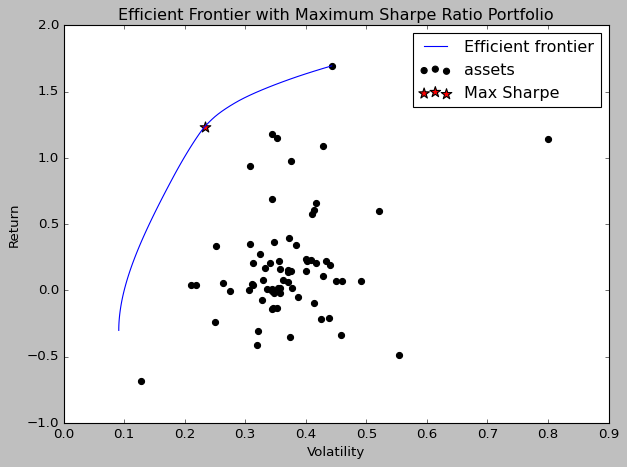

In [48]:
plt.style.use('classic')

# Create a new Efficient Frontier object for plotting
ef_plot = EfficientFrontier(mu, s)

# Plotting the efficient frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Now create a new Efficient Frontier object for finding the tangency portfolio
ef_tangency = EfficientFrontier(mu, s)
ef_tangency.max_sharpe()
ret_tangent, std_tangent, _ = ef_tangency.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Format the matplotlib plot
ax.set_title("Efficient Frontier with Maximum Sharpe Ratio Portfolio")
ax.legend()
plt.tight_layout()
plt.show()

# Filter out portfolio weights that are 0 or very close to 0
non_zero_weights = {ticker: weight for ticker, weight in cleaned_weights.items() if weight > 0}

# Extract the labels and sizes for the pie chart
labels = list(non_zero_weights.keys())
sizes = list(non_zero_weights.values())
sizes = [abs(x) for x in sizes]  # take the absolute value for plotting

# Create the figure for the pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=sizes)])

# Adjust the layout of the pie chart
fig.update_layout(
    title_text='Portfolio Allocation',
    autosize=False,
    width=800,
    height=600,
)

# Improve label positioning
fig.update_traces(
    textinfo='percent+label',
    textfont_size=10,
    marker=dict(line=dict(color='#000000', width=1)),
    pull=[0.05 if size > 10 else 0 for size in sizes],  # Pull out slices with size > 10%
    textposition='inside'
)

# Plotting the portfolio allocation pie chart using Plotly
labels = list(cleaned_weights.keys())
sizes = list(cleaned_weights.values())
sizes = [abs(x) for x in sizes]

# Show the Plotly figure
fig.show()

In [49]:
# Limited Order Size Portfolio

assets = df.columns

# Calculate all assets risk and returns

mu_lim = expected_returns.mean_historical_return(df.ffill())
s_lim = risk_models.CovarianceShrinkage(df.ffill()).ledoit_wolf()


# Use efficient frontier to determine weights

ef_lim = EfficientFrontier(mu_lim, s_lim, weight_bounds=(0, 0.1))
weights_lim = ef_lim.max_sharpe()

cleaned_weights_lim = ef_lim.clean_weights()

print(cleaned_weights_lim)
ef_lim.portfolio_performance(verbose=True)

OrderedDict([('CBOM', 0.1), ('ALRS', 0.0), ('VTBR', 0.0), ('RUAL', 0.0), ('ENPG', 0.0), ('BSPB', 0.1), ('AFKS', 0.0), ('AFLT', 0.0), ('BELU', 0.1), ('GAZP', 0.0), ('GMKN', 0.0), ('LSRG', 0.0), ('POSI', 0.1), ('RENI', 0.05817), ('DSKY', 0.0), ('IRAO', 0.0), ('MVID', 0.0), ('MAGN', 0.0), ('MTLR', 0.0), ('MTLRP', 0.0), ('MTSS', 0.0), ('MOEX', 0.0), ('LKOH', 0.0), ('NLMK', 0.0), ('PIKK', 0.0), ('PLZL', 0.0), ('RTKM', 0.0), ('RTKMP', 0.0), ('SBER', 0.1), ('SBERP', 0.1), ('CHMF', 0.0), ('SELG', 0.0), ('FLOT', 0.0), ('TGKA', 0.0), ('TRNFP', 0.0), ('HYDR', 0.0), ('FEES', 0.0), ('PHOR', 0.0), ('ELFV', 0.0), ('SFIN', 0.02224), ('UPRO', 0.02878), ('SGZH', 0.0), ('RNFT', 0.0024), ('MSNG', 0.0), ('SMLT', 0.0), ('NVTK', 0.0), ('ROSN', 0.0), ('TATN', 0.0), ('TATNP', 0.0), ('AQUA', 0.0), ('AKRN', 0.0), ('APTK', 0.0), ('OGKB', 0.0), ('FESH', 0.0), ('KMAZ', 0.0), ('RASP', 0.0), ('MRKV', 0.0), ('MSRS', 0.0), ('MRKZ', 0.0), ('MRKS', 0.0), ('MRKU', 0.0), ('MRKP', 0.0), ('MRKC', 0.0), ('SVAV', 0.05302), ('S

(0.922097913967947, 0.20803164361633114, 4.336349500904148)

In [50]:
# Calculate allocation

portfolio_val_lim = 1000000
latest_prices_lim = get_latest_prices(df)
weights_lim = cleaned_weights_lim
da_lim = DiscreteAllocation(weights_lim, latest_prices_lim, total_portfolio_value = portfolio_val_lim)
allocation_lim, leftover_lim = da_lim.greedy_portfolio()
print('Discrete Allocation: ', allocation_lim)
print('Funds Remaining: ', leftover_lim)

Discrete Allocation:  {'CBOM': 13971, 'BSPB': 673, 'BELU': 25, 'POSI': 58, 'SBER': 462, 'SBERP': 463, 'TGKN': 24509803, 'TRMK': 999, 'RENI': 1013, 'SVAV': 225, 'MGTSP': 27, 'UPRO': 14928, 'SFIN': 44, 'RNFT': 17}
Funds Remaining:  0.12176000001640652


c:\Users\Gegenubr\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    



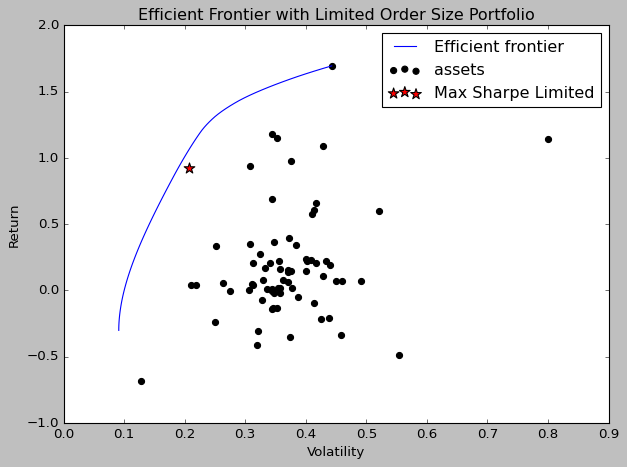

In [51]:
plt.style.use('classic')

# Create a new Efficient Frontier object for plotting
ef_lim_plot = EfficientFrontier(mu_lim, s_lim)

# Plotting the efficient frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_lim_plot, ax=ax, show_assets=True)

# Now create a new Efficient Frontier object for finding the tangency portfolio
ef_lim_tangency = EfficientFrontier(mu_lim, s_lim, weight_bounds=(0, 0.1))
ef_lim_tangency.max_sharpe()
ret_lim_tangent, std_lim_tangent, _ = ef_lim_tangency.portfolio_performance()
ax.scatter(std_lim_tangent, ret_lim_tangent, marker="*", s=100, c="r", label="Max Sharpe Limited")

# Format the matplotlib plot
ax.set_title("Efficient Frontier with Limited Order Size Portfolio")
ax.legend()
plt.tight_layout()
plt.show()

# Filter out portfolio weights that are 0 or very close to 0
non_zero_weights_lim = {ticker_lim: weight for ticker_lim, weight in cleaned_weights_lim.items() if weight > 0}

# Extract the labels and sizes for the pie chart
labels_lim = list(non_zero_weights_lim.keys())
sizes_lim = list(non_zero_weights_lim.values())
sizes_lim = [abs(x) for x in sizes_lim]

# Create the figure for the pie chart
fig_lim = go.Figure(data=[go.Pie(labels=labels_lim, values=sizes_lim)])

# Adjust the layout of the pie chart
fig_lim.update_layout(
    title_text='Portfolio Allocation',
    autosize=False,
    width=800,
    height=600,
)

# Improve label positioning
fig_lim.update_traces(
    textinfo='percent+label',
    textfont_size=10,
    marker=dict(line=dict(color='#000000', width=1)),
    pull=[0.05 if size_lim > 10 else 0 for size_lim in sizes_lim],  # Pull out slices with size > 10%
    textposition='inside'
)

# Show the Plotly figure
fig_lim.show()

In [52]:
# Limited order size portfolio table

non_zero_lim = [name for name, value in cleaned_weights_lim.items() if value > 0]
non_zero_df = df[non_zero_lim]

# Define index symbol
stock = ['IMOEX.ME']

# Fetch data from Yahoo Finance
index = yf.download(stock, start=start, end=end)
index = index.reset_index()
index.rename(columns={'Date': 'TRADEDATE', 'Adj Close': 'IMOEX'}, inplace=True)
index_mer = index[['TRADEDATE', 'IMOEX']]

index_mer = index_mer.round(2)

all_data = non_zero_df.merge(index_mer, on='TRADEDATE', how='outer')

# Sort by TRADEDATE
all_data = all_data.sort_values(by='TRADEDATE')

# Set TRADEDATE as index column
all_data.set_index('TRADEDATE', inplace=True)
all_data = all_data.iloc[:-1]

non_zero_df_lim = all_data
non_zero_df_lim

beta_lim = matrix_beta(non_zero_df_lim)

non_zero_df_lim.drop('IMOEX', axis = 1, inplace = True)
non_zero_df_lim

allocation_lim = {col: allocation_lim[col] for col in non_zero_df_lim.columns if col in allocation_lim}

units_lim = np.array(list(allocation_lim.values()))
price_nested_lim = non_zero_df_lim.iloc[-1:].values.tolist()
price_lim = price_nested_lim[0]
value_lim = [unit*pr for unit, pr in zip(units_lim, price_lim)]
weight_lim = np.array(list(cleaned_weights_lim.values()))
non_zero_weight_lim = [value for value in weight_lim if value > 0]

Portfolio_lim = pd.DataFrame({
    'Stock': non_zero_df_lim.columns.tolist(),
    'Direction': 'Long',
    'Type': 'S',
    'Stock Price': price_lim,
    'Price': price_lim,
    'Units': units_lim,
    'Value': units_lim*price_lim,
    'Weight': non_zero_weight_lim,
    'Beta': beta_lim,
    })
Portfolio_lim

[*********************100%%**********************]  1 of 1 completed


,Stock,Direction,Type,Stock Price,Price,Units,Value,Weight,Beta
CBOM,CBOM,Long,S,7.44100,7.44100,13971,103958.21100,0.10000,0.000872
BSPB,BSPB,Long,S,149.96000,149.96000,673,100923.08000,0.10000,0.042779
BELU,BELU,Long,S,4023.00000,4023.00000,25,100575.00000,0.10000,1.055396
POSI,POSI,Long,S,1716.00000,1716.00000,58,99528.00000,0.10000,0.594174
RENI,RENI,Long,S,54.60000,54.60000,1013,55309.80000,0.05817,0.016623
SBER,SBER,Long,S,216.87000,216.87000,462,100193.94000,0.10000,0.098435
SBERP,SBERP,Long,S,216.80000,216.80000,463,100378.40000,0.10000,0.097403
SFIN,SFIN,Long,S,508.00000,508.00000,44,22352.00000,0.02224,0.108234
UPRO,UPRO,Long,S,1.94300,1.94300,14928,29005.10400,0.02878,0.000771
RNFT,RNFT,Long,S,125.40000,125.40000,17,2131.80000,0.00240,0.054010


In [53]:
# Minimum Volatility Portfolio

assets = df.columns

# Calculate all assets risk and returns

mu_vol = expected_returns.mean_historical_return(df.ffill())
s_vol = risk_models.CovarianceShrinkage(df.ffill()).ledoit_wolf()


# Use efficient frontier to determine weights

ef_vol = EfficientFrontier(mu_vol, s_vol)
weights_vol = ef_vol.min_volatility()

cleaned_weights_vol = ef_vol.clean_weights()

print(cleaned_weights_vol)
ef_vol.portfolio_performance(verbose=True)

OrderedDict([('CBOM', 0.03886), ('ALRS', 0.0), ('VTBR', 0.0), ('RUAL', 0.0), ('ENPG', 0.0), ('BSPB', 0.00099), ('AFKS', 0.0), ('AFLT', 0.0), ('BELU', 0.02071), ('GAZP', 0.0), ('GMKN', 0.0), ('LSRG', 0.0), ('POSI', 0.0), ('RENI', 0.00762), ('DSKY', 0.0), ('IRAO', 0.0), ('MVID', 0.0), ('MAGN', 0.0), ('MTLR', 0.0), ('MTLRP', 0.0), ('MTSS', 0.0), ('MOEX', 0.0), ('LKOH', 0.0), ('NLMK', 0.0), ('PIKK', 0.0), ('PLZL', 0.0), ('RTKM', 0.0), ('RTKMP', 0.06919), ('SBER', 0.0), ('SBERP', 0.0), ('CHMF', 0.0), ('SELG', 0.0), ('FLOT', 0.0), ('TGKA', 0.0), ('TRNFP', 0.0), ('HYDR', 0.03194), ('FEES', 0.0), ('PHOR', 0.00616), ('ELFV', 0.50659), ('SFIN', 0.0488), ('UPRO', 0.0), ('SGZH', 0.0), ('RNFT', 0.0), ('MSNG', 0.01271), ('SMLT', 0.0), ('NVTK', 0.0), ('ROSN', 0.0), ('TATN', 0.0), ('TATNP', 0.0), ('AQUA', 0.0), ('AKRN', 0.0), ('APTK', 0.10739), ('OGKB', 0.0), ('FESH', 0.0), ('KMAZ', 0.0), ('RASP', 0.0), ('MRKV', 0.00071), ('MSRS', 0.0), ('MRKZ', 0.0), ('MRKS', 0.00758), ('MRKU', 0.0), ('MRKP', 0.0), (

(-0.3011562192377231, 0.09126183006864746, -3.519063983224403)

In [54]:
# Calculate allocation

portfolio_val = 1000000
latest_prices_vol = get_latest_prices(df)
weights_vol = cleaned_weights_vol
da_vol = DiscreteAllocation(weights_vol, latest_prices_vol, total_portfolio_value = portfolio_val)
allocation_vol, leftover_vol = da_vol.greedy_portfolio()
print('Discrete Allocation: ', allocation_vol)
print('Funds Remaining: ', leftover_vol)

Discrete Allocation:  {'ELFV': 884409, 'VSMO': 2, 'APTK': 8255, 'RTKMP': 1141, 'SFIN': 95, 'CBOM': 5428, 'HYDR': 38903, 'TGKN': 6421568, 'BELU': 6, 'MSNG': 5522, 'RENI': 132, 'MRKS': 22359, 'PHOR': 1, 'SVAV': 7, 'BSPB': 7, 'MRKV': 19749}
Funds Remaining:  15281.679810000009


c:\Users\Gegenubr\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    



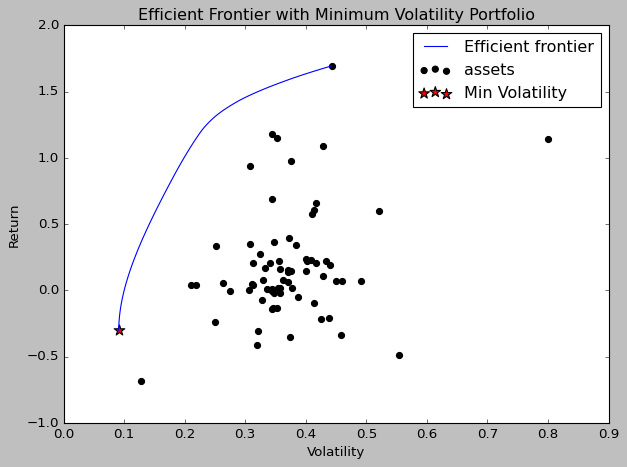

In [55]:
plt.style.use('classic')

# Create a new Efficient Frontier object for plotting
ef_vol_plot = EfficientFrontier(mu_vol, s_vol)

# Plotting the efficient frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_vol_plot, ax=ax, show_assets=True)

# Now create a new Efficient Frontier object for finding the tangency portfolio
ef_vol_tangency = EfficientFrontier(mu_vol, s_vol)
ef_vol_tangency.min_volatility()
ret_vol_tangent, std_vol_tangent, _ = ef_vol_tangency.portfolio_performance()
ax.scatter(std_vol_tangent, ret_vol_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format the matplotlib plot
ax.set_title("Efficient Frontier with Minimum Volatility Portfolio")
ax.legend()
plt.tight_layout()
plt.show()

# Filter out portfolio weights that are 0 or very close to 0
non_zero_weights_vol = {ticker_vol: weight for ticker_vol, weight in cleaned_weights_vol.items() if weight > 0}

# Extract the labels and sizes for the pie chart
labels_vol = list(non_zero_weights_vol.keys())
sizes_vol = list(non_zero_weights_vol.values())
sizes_vol = [abs(x) for x in sizes_vol]

# Create the figure for the pie chart
fig_vol = go.Figure(data=[go.Pie(labels=labels_vol, values=sizes_vol)])

# Adjust the layout of the pie chart
fig_vol.update_layout(
    title_text='Portfolio Allocation',
    autosize=False,
    width=800,
    height=600,
)

# Improve label positioning
fig_vol.update_traces(
    textinfo='percent+label',
    textfont_size=10,
    marker=dict(line=dict(color='#000000', width=1)),
    pull=[0.05 if size_vol > 10 else 0 for size_vol in sizes_vol],  # Pull out slices with size > 10%
    textposition='inside'
)

# Show the Plotly figure
fig_vol.show()

In [56]:
# Minimum volatility portfolio table

non_zero_vol = [name for name, value in cleaned_weights_vol.items() if value > 0]
non_zero_df = df[non_zero_vol]

# Define index symbol
stock = ['IMOEX.ME']

# Fetch data from Yahoo Finance
index = yf.download(stock, start=start, end=end)
index = index.reset_index()
index.rename(columns={'Date': 'TRADEDATE', 'Adj Close': 'IMOEX'}, inplace=True)
index_mer = index[['TRADEDATE', 'IMOEX']]

index_mer = index_mer.round(2)

all_data = non_zero_df.merge(index_mer, on='TRADEDATE', how='outer')

# Sort by TRADEDATE
all_data = all_data.sort_values(by='TRADEDATE')

# Set TRADEDATE as index column
all_data.set_index('TRADEDATE', inplace=True)
all_data = all_data.iloc[:-1]

non_zero_df_vol = all_data
non_zero_df_vol

beta_vol = matrix_beta(non_zero_df_vol)

non_zero_df_vol.drop('IMOEX', axis = 1, inplace = True)
non_zero_df_vol

allocation_vol = {col: allocation_vol[col] for col in non_zero_df_vol.columns if col in allocation_vol}

units_vol = np.array(list(allocation_vol.values()))
price_nested_vol = non_zero_df_vol.iloc[-1:].values.tolist()
price_vol = price_nested_vol[0]
value_vol = [unit*pr for unit, pr in zip(units_vol, price_vol)]
weight_vol = np.array(list(cleaned_weights_vol.values()))
non_zero_weight_vol = [value for value in weight_vol if value > 0]

Portfolio_vol = pd.DataFrame({
    'Stock': non_zero_df_vol.columns.tolist(),
    'Direction': 'Long',
    'Type': 'S',
    'Stock Price': price_vol,
    'Price': price_vol,
    'Units': units_vol,
    'Value': units_vol*price_vol,
    'Weight': non_zero_weight_vol,
    'Beta': beta_vol,
    })
Portfolio_vol

[*********************100%%**********************]  1 of 1 completed


,Stock,Direction,Type,Stock Price,Price,Units,Value,Weight,Beta
CBOM,CBOM,Long,S,7.44100,7.44100,5428,40389.74800,0.03886,0.000872
BSPB,BSPB,Long,S,149.96000,149.96000,7,1049.72000,0.00099,0.042779
BELU,BELU,Long,S,4023.00000,4023.00000,6,24138.00000,0.02071,1.055396
RENI,RENI,Long,S,54.60000,54.60000,132,7207.20000,0.00762,0.016623
RTKMP,RTKMP,Long,S,60.70000,60.70000,1141,69258.70000,0.06919,0.012603
HYDR,HYDR,Long,S,0.82310,0.82310,38903,32021.05930,0.03194,0.000225
PHOR,PHOR,Long,S,7419.00000,7419.00000,1,7419.00000,0.00616,3.223570
ELFV,ELFV,Long,S,0.57860,0.57860,884409,511719.04740,0.50659,NaN
SFIN,SFIN,Long,S,508.00000,508.00000,95,48260.00000,0.04880,0.108234
MSNG,MSNG,Long,S,2.31950,2.31950,5522,12808.27900,0.01271,0.001049


In [57]:
# Maximum Return Portfolio

# Calculate all assets risk and returns
mu_max_return = expected_returns.mean_historical_return(df.ffill())
s_max_return = risk_models.CovarianceShrinkage(df.ffill()).ledoit_wolf()

# Use efficient frontier to determine weights for the maximum return
ef_max_return = EfficientFrontier(mu_max_return, s_max_return)

# Find the highest expected return from the assets
max_return = max(mu_max_return)-0.01

# Get the portfolio weights that target the maximum return
weights_max_return = ef_max_return.efficient_return(target_return=max_return)

cleaned_weights_max_return = ef_max_return.clean_weights()
print(cleaned_weights_max_return)
ef_max_return.portfolio_performance(verbose=True)


OrderedDict([('CBOM', 0.0), ('ALRS', 0.0), ('VTBR', 0.0), ('RUAL', 0.0), ('ENPG', 0.0), ('BSPB', 0.98048), ('AFKS', 0.0), ('AFLT', 0.0), ('BELU', 0.0), ('GAZP', 0.0), ('GMKN', 0.0), ('LSRG', 0.0), ('POSI', 0.01952), ('RENI', 0.0), ('DSKY', 0.0), ('IRAO', 0.0), ('MVID', 0.0), ('MAGN', 0.0), ('MTLR', 0.0), ('MTLRP', 0.0), ('MTSS', 0.0), ('MOEX', 0.0), ('LKOH', 0.0), ('NLMK', 0.0), ('PIKK', 0.0), ('PLZL', 0.0), ('RTKM', 0.0), ('RTKMP', 0.0), ('SBER', 0.0), ('SBERP', 0.0), ('CHMF', 0.0), ('SELG', 0.0), ('FLOT', 0.0), ('TGKA', 0.0), ('TRNFP', 0.0), ('HYDR', 0.0), ('FEES', 0.0), ('PHOR', 0.0), ('ELFV', 0.0), ('SFIN', 0.0), ('UPRO', 0.0), ('SGZH', 0.0), ('RNFT', 0.0), ('MSNG', 0.0), ('SMLT', 0.0), ('NVTK', 0.0), ('ROSN', 0.0), ('TATN', 0.0), ('TATNP', 0.0), ('AQUA', 0.0), ('AKRN', 0.0), ('APTK', 0.0), ('OGKB', 0.0), ('FESH', 0.0), ('KMAZ', 0.0), ('RASP', 0.0), ('MRKV', 0.0), ('MSRS', 0.0), ('MRKZ', 0.0), ('MRKS', 0.0), ('MRKU', 0.0), ('MRKP', 0.0), ('MRKC', 0.0), ('SVAV', 0.0), ('SNGS', 0.0),

c:\Users\Gegenubr\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    



(1.684635865963877, 0.4365508838261965, 3.813154268235582)

In [58]:
# Calculate allocation

portfolio_val = 1000000
latest_prices_max_return = get_latest_prices(df)
weights_max_return = cleaned_weights_max_return
da_max_return = DiscreteAllocation(weights_max_return, latest_prices_max_return, total_portfolio_value = portfolio_val)
allocation_max_return, leftover_max_return = da_max_return.greedy_portfolio()
print('Discrete Allocation: ', allocation_max_return)
print('Funds Remaining: ', leftover_max_return)

Discrete Allocation:  {'BSPB': 6602, 'POSI': 11}
Funds Remaining:  718.2000000000007


c:\Users\Gegenubr\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    



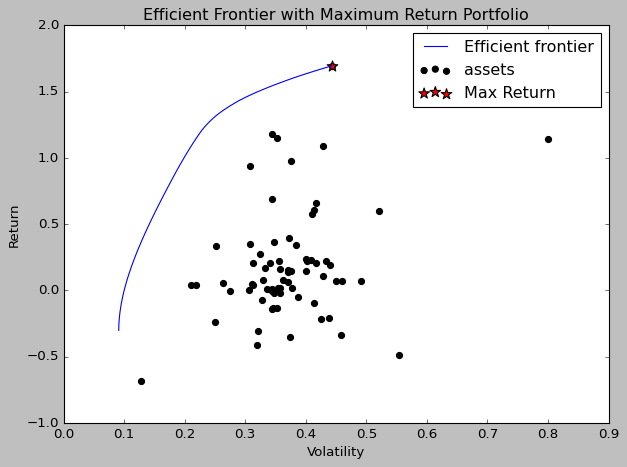

In [59]:
plt.style.use('classic')

# Create a new Efficient Frontier object for plotting
ef_max_ret_plot = EfficientFrontier(mu_max_return, s_max_return)

# Plotting the efficient frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_max_ret_plot, ax=ax, show_assets=True)

# Calculate the maximum return portfolio instead of the minimum volatility
ef_max_return = EfficientFrontier(mu_max_return, s_max_return)
max_return = max(mu_max_return) - 0.00001
weights_max_return = ef_max_return.efficient_return(target_return=max_return)
cleaned_weights_max_return = ef_max_return.clean_weights()
ret_max_return, std_max_return, _ = ef_max_return.portfolio_performance()
ax.scatter(std_max_return, ret_max_return, marker="*", s=100, c="r", label="Max Return")

# Format the matplotlib plot
ax.set_title("Efficient Frontier with Maximum Return Portfolio")
ax.legend()
plt.tight_layout()
plt.show()  # Display the matplotlib plot

# Filter out portfolio weights that are 0
non_zero_weights_max_return = {ticker: weight for ticker, weight in cleaned_weights_max_return.items() if weight > 0}

# Extract the labels and sizes for the pie chart
labels_max_return = list(non_zero_weights_max_return.keys())
sizes_max_return = list(non_zero_weights_max_return.values())
sizes_max_return = [abs(x) for x in sizes_max_return]  # take the absolute value for plotting

# Create the figure for the pie chart
fig_max_return = go.Figure(data=[go.Pie(labels=labels_max_return, values=sizes_max_return)])

# Adjust the layout of the pie chart
fig_max_return.update_layout(
    title_text='Portfolio Allocation',
    autosize=False,
    width=800,
    height=600,
)

# Improve label positioning
fig_max_return.update_traces(
    textinfo='percent+label',
    textfont_size=10,
    marker=dict(line=dict(color='#000000', width=1)),
    pull=[0.05 if size > 10 else 0 for size in sizes_max_return],  # Pull out slices with size > 10%
    textposition='inside'
)

# Show the Plotly figure
fig_max_return.show()

In [60]:
# Maximum return portfolio table

non_zero_max_return = [name for name, value in cleaned_weights_max_return.items() if value > 0]
non_zero_df = df[non_zero_max_return]

# Define index symbol
stock = ['IMOEX.ME']

# Fetch data from Yahoo Finance
index = yf.download(stock, start=start, end=end)
index = index.reset_index()
index.rename(columns={'Date': 'TRADEDATE', 'Adj Close': 'IMOEX'}, inplace=True)
index_mer = index[['TRADEDATE', 'IMOEX']]

index_mer = index_mer.round(2)

all_data = non_zero_df.merge(index_mer, on='TRADEDATE', how='outer')

# Sort by TRADEDATE
all_data = all_data.sort_values(by='TRADEDATE')

# Set TRADEDATE as index column
all_data.set_index('TRADEDATE', inplace=True)
all_data = all_data.iloc[:-1]

non_zero_df_max_return = all_data
non_zero_df_max_return

beta_max_return = matrix_beta(non_zero_df_max_return)

non_zero_df_max_return.drop('IMOEX', axis = 1, inplace = True)
non_zero_df_max_return

allocation_max_return = {col: allocation_max_return[col] for col in non_zero_df_max_return.columns if col in allocation_max_return}

units_max_return = np.array(list(allocation_max_return.values()))
price_nested_max_return = non_zero_df_max_return.iloc[-1:].values.tolist()
price_max_return = price_nested_max_return[0]
value_max_return = [unit*pr for unit, pr in zip(units_max_return, price_max_return)]
weight_max_return = np.array(list(cleaned_weights_max_return.values()))
non_zero_weight_max_return = [value for value in weight_max_return if value > 0]

Portfolio_max_return = pd.DataFrame({
    'Stock': non_zero_df_max_return.columns.tolist(),
    'Direction': 'Long',
    'Type': 'S',
    'Stock Price': price_max_return,
    'Price': price_max_return,
    'Units': units_max_return,
    'Value': units_max_return*price_max_return,
    'Weight': non_zero_weight_max_return,
    'Beta': beta_max_return,
    })
Portfolio_max_return

[*********************100%%**********************]  1 of 1 completed


,Stock,Direction,Type,Stock Price,Price,Units,Value,Weight,Beta
BSPB,BSPB,Long,S,149.96,149.96,6602,990035.92,0.99998,0.042779


In [61]:
non_zero = [name for name, value in cleaned_weights.items() if value > 0]
non_zero_df = df[non_zero]

# Define index symbol
stock = ['IMOEX.ME']

# Fetch data from Yahoo Finance
index = yf.download(stock, start=start, end=end)
index = index.reset_index()
index.rename(columns={'Date': 'TRADEDATE', 'Adj Close': 'IMOEX'}, inplace=True)
index_mer = index[['TRADEDATE', 'IMOEX']]

index_mer = index_mer.round(2)

all_data = non_zero_df.merge(index_mer, on='TRADEDATE', how='outer')

# Sort by TRADEDATE
all_data = all_data.sort_values(by='TRADEDATE')

# Set TRADEDATE as index column
all_data.set_index('TRADEDATE', inplace=True)
all_data = all_data.iloc[:-1]

non_zero_df = all_data
non_zero_df

[*********************100%%**********************]  1 of 1 completed

,BSPB,BELU,POSI,SBERP,TGKN,TRMK,IMOEX
TRADEDATE,,,,,,,
2022-06-01,64.50,2312,890.4,113.19,0.00262,53.90,2374.60
2022-06-02,64.78,2296,882.2,112.11,0.00261,52.64,2340.17
2022-06-03,65.22,2275,879.8,112.02,0.00262,51.74,2308.03
2022-06-06,66.80,2336,860.0,113.70,0.00263,51.70,2282.16
2022-06-07,66.22,2330,850.0,113.00,0.00264,52.02,2291.62
...,...,...,...,...,...,...,...
2023-03-24,155.20,3894,1702.8,203.68,0.00360,95.90,2391.53
2023-03-27,154.00,4009,1708.0,211.94,0.00366,104.48,2440.68
2023-03-28,152.10,4038,1703.2,213.90,0.00380,103.00,2442.19


In [62]:
beta = matrix_beta(non_zero_df)
beta

BSPB     0.042779
BELU     1.055396
POSI     0.594174
SBERP    0.097403
TGKN     0.000002
TRMK     0.027841
Name: Beta, dtype: float64

In [63]:
non_zero_df.drop('IMOEX', axis = 1, inplace = True)
non_zero_df

,BSPB,BELU,POSI,SBERP,TGKN,TRMK
TRADEDATE,,,,,,
2022-06-01,64.50,2312,890.4,113.19,0.00262,53.90
2022-06-02,64.78,2296,882.2,112.11,0.00261,52.64
2022-06-03,65.22,2275,879.8,112.02,0.00262,51.74
2022-06-06,66.80,2336,860.0,113.70,0.00263,51.70
2022-06-07,66.22,2330,850.0,113.00,0.00264,52.02
...,...,...,...,...,...,...
2023-03-24,155.20,3894,1702.8,203.68,0.00360,95.90
2023-03-27,154.00,4009,1708.0,211.94,0.00366,104.48
2023-03-28,152.10,4038,1703.2,213.90,0.00380,103.00


In [64]:
allocation = {col: allocation[col] for col in non_zero_df.columns if col in allocation}

units = np.array(list(allocation.values()))
price_nested = non_zero_df.iloc[-1:].values.tolist()
price = price_nested[0]
value = [unit*pr for unit, pr in zip(units, price)]
weight = np.array(list(cleaned_weights.values()))
non_zero_weight = [value for value in weight if value > 0]

In [65]:
Portfolio = pd.DataFrame({
    'Stock': non_zero_df.columns.tolist(),
    'Direction': 'Long',
    'Type': 'S',
    'Stock Price': price,
    'Price': price,
    'Units': units,
    'Value': units*price,
    'Weight': non_zero_weight,
    'Beta': beta,
    'Weighted Beta': non_zero_weight*beta
})
Portfolio

,Stock,Direction,Type,Stock Price,Price,Units,Value,Weight,Beta,Weighted Beta
BSPB,BSPB,Long,S,149.96000,149.96000,1862,279225.5200,0.27657,0.042779,1.183144e-02
BELU,BELU,Long,S,4023.00000,4023.00000,46,185058.0000,0.18781,1.055396,1.982139e-01
POSI,POSI,Long,S,1716.00000,1716.00000,140,240240.0000,0.24064,0.594174,1.429820e-01
SBERP,SBERP,Long,S,216.80000,216.80000,482,104497.6000,0.10416,0.097403,1.014545e-02
TGKN,TGKN,Long,S,0.00415,0.00415,13656862,56675.9773,0.05572,0.000002,1.023476e-07
TRMK,TRMK,Long,S,100.72000,100.72000,1349,135871.2800,0.13509,0.027841,3.761001e-03


In [66]:
Portfolio = Portfolio.drop(['Weight', 'Weighted Beta'], axis=1)
Portfolio['Delta'] = Portfolio['Units']
Portfolio

,Stock,Direction,Type,Stock Price,Price,Units,Value,Beta,Delta
BSPB,BSPB,Long,S,149.96000,149.96000,1862,279225.5200,0.042779,1862
BELU,BELU,Long,S,4023.00000,4023.00000,46,185058.0000,1.055396,46
POSI,POSI,Long,S,1716.00000,1716.00000,140,240240.0000,0.594174,140
SBERP,SBERP,Long,S,216.80000,216.80000,482,104497.6000,0.097403,482
TGKN,TGKN,Long,S,0.00415,0.00415,13656862,56675.9773,0.000002,13656862
TRMK,TRMK,Long,S,100.72000,100.72000,1349,135871.2800,0.027841,1349


In [67]:
def black_scholes_call(S, X, T, r, sigma):
    # Calculate d1 and d2 parameters
    d1 = (np.log(S / X) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Calculate call option price
    call_price = (S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2))
    return call_price

def black_scholes_put(S, X, T, r, sigma):
    # Calculate d1 and d2 parameters
    d1 = (np.log(S / X) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Calculate put option price
    put_price = (X * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    return put_price

def call_option_delta(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def put_option_delta(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) - 1

In [68]:
stock_list = ['SBERP', 'BELU']

volatility_dict = {}
for stock in stock_list:
    stock_prices = non_zero_df[stock]
    returns = stock_prices.pct_change()
    volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    volatility_dict[stock] = volatility

# Copy the portfolio DataFrame to not alter the original
updated_portfolio_df = Portfolio.copy()

# Iterate through portfolio, calculate options characteristics, and append new rows
for index, row in Portfolio.iterrows():
    stock = row['Stock']
    if stock in volatility_dict:
        S = row['Stock Price']
        rt = 0.15  # Risk tolerance of investor
        X = S * (1 - rt)  # Option strike price
        T = 1  # Time to expiration in years
        r = 0.10  # Risk-free interest rate
        sigma = volatility_dict[stock]  # Volatility of the underlying stock

        # Calculate options characteristics for put options
        put_price = black_scholes_put(S, X, T, r, sigma)
        put_delta = put_option_delta(S, X, T, r, sigma)

        # Calculate number of options needed to fully cover the delta
        options_needed_put = np.round(abs(row['Units'] / put_delta))  # Round to nearest whole number

        # Create new row for put options
        option_row = row.copy()
        option_row['Type'] = 'Put'
        option_row['Price'] = put_price
        option_row['Units'] = options_needed_put  # Use rounded units
        option_row['Value'] = put_price * options_needed_put
        option_row['Delta'] = put_delta * options_needed_put

        # Append the new option row to the updated portfolio DataFrame
        updated_portfolio_df = pd.concat([updated_portfolio_df, pd.DataFrame([option_row])], ignore_index=True)

# The 'updated_portfolio_df' now contains the original portfolio plus the new options data
updated_portfolio_df.set_index('Stock', inplace = True)
updated_portfolio_df['Delta'] = updated_portfolio_df['Delta'].apply(lambda x: f"{x:.2f}")
updated_portfolio_df

,Direction,Type,Stock Price,Price,Units,Value,Beta,Delta
Stock,,,,,,,,
BSPB,Long,S,149.96000,149.960000,1862.0,279225.520000,0.042779,1862.00
BELU,Long,S,4023.00000,4023.000000,46.0,185058.000000,1.055396,46.00
POSI,Long,S,1716.00000,1716.000000,140.0,240240.000000,0.594174,140.00
SBERP,Long,S,216.80000,216.800000,482.0,104497.600000,0.097403,482.00
TGKN,Long,S,0.00415,0.004150,13656862.0,56675.977300,0.000002,13656862.00
TRMK,Long,S,100.72000,100.720000,1349.0,135871.280000,0.027841,1349.00
BELU,Long,Put,4023.00000,110.171599,302.0,33271.822900,1.055396,-46.05
SBERP,Long,Put,216.80000,8.640682,2717.0,23476.733232,0.097403,-481.97


In [69]:
list_keys = [key for key in non_zero_weights_lim]
list_weights = [weight for weight in non_zero_weights_lim.values()]

df_mc = df[list_keys] 
returns = df_mc.pct_change().dropna()
mean_returns = returns.mean()
cov = returns.cov()
returns['Portfolio'] = returns.dot(list_weights)
returns

,CBOM,BSPB,BELU,POSI,RENI,SBER,SBERP,SFIN,UPRO,RNFT,SVAV,TGKN,TRMK,MGTSP,Portfolio
TRADEDATE,,,,,,,,,,,,,,,
2022-06-02,-0.012496,0.004341,-0.006920,-0.009209,0.023012,-0.024350,-0.009541,0.006252,-0.011120,-0.004435,-0.014085,-0.003817,-0.023377,-0.002924,-0.008240
2022-06-03,-0.012834,0.006792,-0.009146,-0.002720,0.038490,0.001765,-0.000803,0.016311,-0.012048,-0.037862,-0.008571,0.003831,-0.017097,-0.032258,-0.002454
2022-06-06,-0.003479,0.024226,0.026813,-0.022505,0.049097,-0.003607,0.014997,0.006114,0.000000,-0.004630,0.008646,0.003817,-0.000773,-0.009091,0.007066
2022-06-07,-0.001654,-0.008683,-0.002568,-0.011628,0.008718,-0.003873,-0.006157,-0.010254,-0.008130,0.027907,-0.002857,0.003802,0.006190,0.039755,-0.001089
2022-06-08,-0.031842,0.013591,-0.003863,0.013882,0.025244,0.013354,0.018938,0.024559,-0.014754,0.013575,-0.002865,-0.007576,-0.002691,-0.008824,0.002538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,0.017197,-0.007732,0.029533,0.003054,0.007061,0.040625,0.040554,0.005948,0.029300,-0.005660,0.008386,0.016667,0.089468,0.013699,0.025239
2023-03-28,0.035071,-0.012338,0.007234,-0.002810,-0.009963,0.010338,0.009248,0.001577,0.052188,-0.005693,-0.006237,0.038251,-0.014165,-0.006006,0.007483
2023-03-29,0.006210,-0.013215,-0.001486,0.003875,0.015654,0.018502,0.017625,-0.001574,-0.019038,-0.001908,-0.004184,-0.013158,-0.002913,-0.009063,0.001324


Text(0.5, 1.0, 'MC simulation of a stock portfolio')

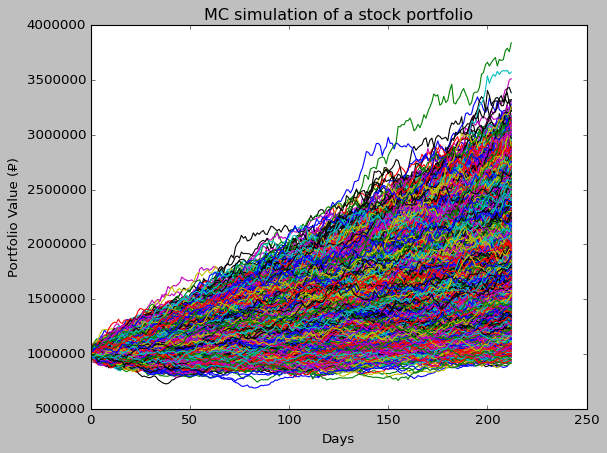

In [70]:
# Monte Carlo Method
mc_sims = 10000
T = 213 #timeframe in days

meanM = np.full(shape=(T, len(list_weights)), fill_value=mean_returns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

portfolio_val = 1000000

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(list_weights)))
    L = np.linalg.cholesky(cov)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(list_weights, dailyReturns.T)+1)*portfolio_val

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value (₽)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')

In [71]:
def mcCVaR(returns, alpha=5):
    
    if isinstance(returns, pd.Series):
        belowVaR = returns <= np.percentile(returns, alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [72]:
port_results = pd.Series(portfolio_sims[-1,:])

VaR = (np.percentile(port_results, 5))
CVaR = mcCVaR(port_results, alpha=5)

print('VaR ₽{}'.format(round(VaR,2)))
print('CVaR ₽{}'.format(round(CVaR,2)))

VaR ₽1286287.58
CVaR ₽1185345.33


In [73]:
round(np.mean(port_results), 2)

1816467.56